In [22]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from datasets import load_dataset
import numpy as np
# Print the length of dataset train dialogue and summary in histogram
import matplotlib.pyplot as plt


In [23]:
def reduce_dataset_sizes(dataset, train_split=100, val_split=20, test_split=30):
    for (
        split_name
    ) in dataset.keys():  # Iterate through all splits ('train', 'validation', 'test')

        if split_name == "train":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(train_split))

        if split_name == "validation":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(val_split))

        if split_name == "test":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(test_split))

        dataset[split_name] = reduced_split
    return dataset

In [24]:
from datasets import load_dataset

dataset = load_dataset("knkarthick/dialogsum")
print('Train size:', len(dataset["train"]))
print('Validation size:', len(dataset["validation"]))
print('Test size:', len(dataset["test"]))

Train size: 12460
Validation size: 500
Test size: 1500


In [25]:
reduced_ds = reduce_dataset_sizes(dataset)
print('Train size:', len(reduced_ds["train"]))
print('Validation size:', len(reduced_ds["validation"]))
print('Test size:', len(reduced_ds["test"]))

Train size: 100
Validation size: 20
Test size: 30


In [26]:
def tokenize_dataset(
    dataset,
    tokenizer,
    params=None,
):
    if params is not None:  
      max_source_length = params["max_source_length"]
      max_target_length = params["max_target_length"]
      prefix = params["prefix"]
    else:
      max_source_length = None
      max_target_length = None
      prefix = ""

    def tokenize_function(examples):
        inputs = [prefix + doc for doc in examples["dialogue"]]
        summaries = examples["summary"]

        # Tokenize inputs and targets (summaries)
        model_inputs = tokenizer(
            inputs,
            max_length=max_source_length,
            truncation=True,
        )

        model_target = tokenizer(
            text_target=summaries,
            max_length=max_target_length,
            truncation=True,
        )

        # Directly assign labels to model inputs
        model_inputs["labels"] = model_target["input_ids"]

        return model_inputs

    # Tokenizing and returning dataset with optimized structure
    return dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=["dialogue", "summary", "topic"],  # Remove original text columns
    )

In [27]:

model_path = "facebook/bart-large-xsum"
tokenizer = BartTokenizer.from_pretrained(model_path)

tokenized_ds = tokenize_dataset(dataset, tokenizer)

In [36]:
def print_histogram(dialogues, summaries, dataset_type):
  dialogue_lengths = [len(dialogue) for dialogue in dialogues]
  summary_lengths = [len(summary) for summary in summaries]

  print(len([len(dialogue) for dialogue in dialogues if len(dialogue) > 512]))
  print(len([len(summary) for summary in summaries if len(summary) > 128]))

  # Have more label in x axis
  plt.hist(dialogue_lengths, bins=20)
  plt.xlabel("Dialogue Length")
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Dialogue Lengths ({dataset_type})")
  plt.show()

  plt.hist(summary_lengths, bins=20)
  plt.xlabel("Summary Length")  
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Summary Lengths ({dataset_type})")
  plt.show()

1
1


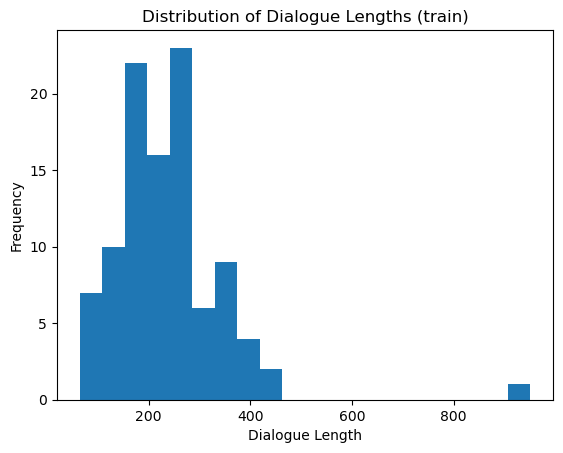

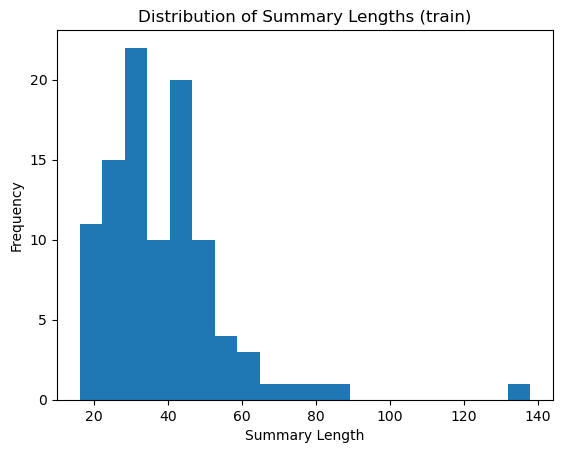

0
0


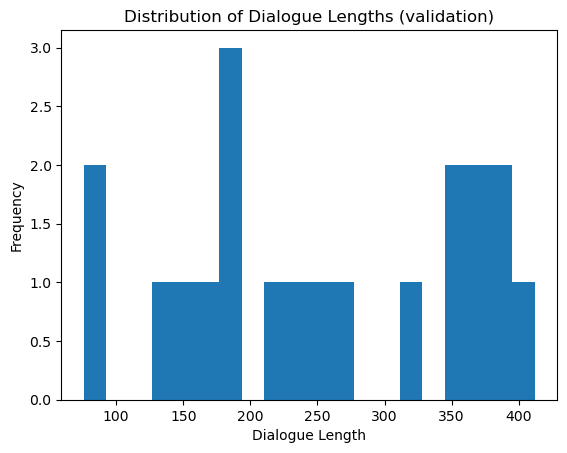

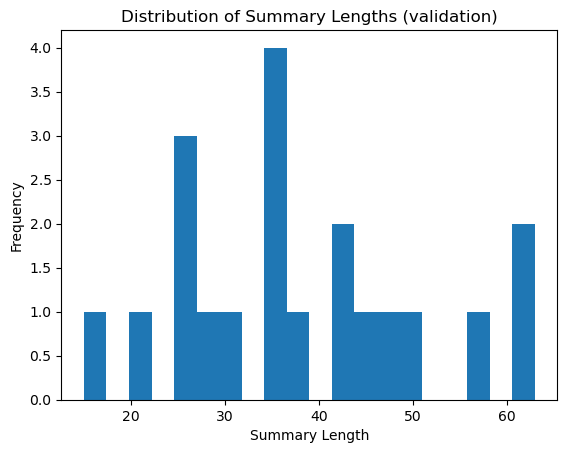

In [37]:


train_dialogue = tokenized_ds["train"]["input_ids"]
train_summary = tokenized_ds["train"]["labels"]

val_dialogue = tokenized_ds["validation"]["input_ids"]
val_summary = tokenized_ds["validation"]["labels"]

print_histogram(train_dialogue, train_summary, 'train')
print_histogram(val_dialogue, val_summary, "validation")


